## GMM-Based Synthetic Sampling for Imbalanced Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import ClusterCentroids
from sklearn.utils import shuffle
from sklearn.cluster import KMeans


### Part A: Baseline Model and Data Analysis

#### 1. Data Loading and Analysis

In [10]:
df = pd.read_csv('creditcard.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There are total of 30 features and one output class feature

In [12]:
df.isna().sum().sum()

np.int64(0)

No null values in the dataset.

#### Standardizing the time and amount features

In [13]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

print("Dataset loaded with standardized 'Time' and 'Amount'.")
df.head()

Dataset loaded with standardized 'Time' and 'Amount'.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Now every feature in the dataset is transformed.

In [14]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [15]:
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (284807, 31)
       Time        V1        V2        V3        V4        V5        V6  \
0 -1.996583 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -1.996583  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -1.996562 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -1.996562 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -1.996541 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V2

- #### Class Distribution

In [16]:
class_counts = df['Class'].value_counts()
print("\nClass distribution:")
print(class_counts)


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [17]:
print("\nPercentage distribution:")
print(class_counts / len(df) * 100)


Percentage distribution:
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


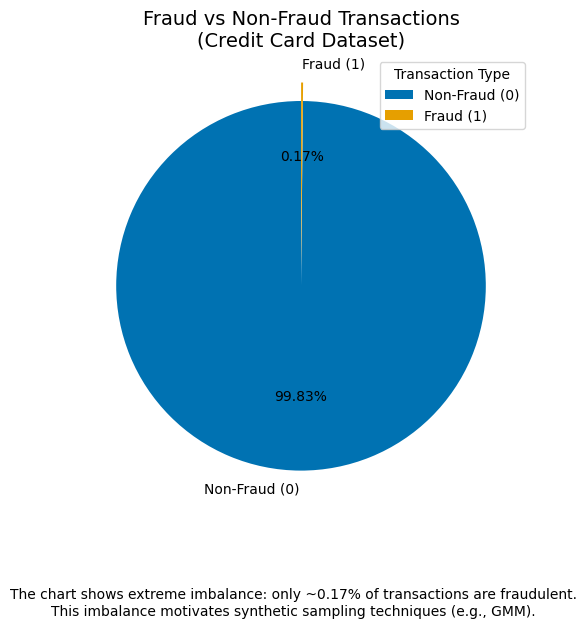

In [18]:

labels = ["Non-Fraud (0)", "Fraud (1)"]

# Colors: use color-blind safe palette
colors = ["#0072B2", "#E69F00"] 
# Pie chart
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(class_counts,
                                  labels=labels,
                                  autopct='%1.2f%%',
                                  startangle=90,
                                  colors=colors,
                                  explode=(0,0.1),
                                  shadow=False)

plt.title("Fraud vs Non-Fraud Transactions\n(Credit Card Dataset)", fontsize=14)

plt.legend(wedges, labels, title="Transaction Type", loc="best")

plt.figtext(0.5, -0.05,
            "The chart shows extreme imbalance: only ~0.17% of transactions are fraudulent.\n"
            "This imbalance motivates synthetic sampling techniques (e.g., GMM).",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()


#### 2. Model Training

In [19]:
# Features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,   # ensures class ratio is preserved
    random_state=42
)

print("Training set size:", X_train.shape, "Testing set size:", X_test.shape)
print("\nClass distribution in Training set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass distribution in Test set:")
print(y_test.value_counts(normalize=True) * 100)

Training set size: (199364, 30) Testing set size: (85443, 30)

Class distribution in Training set:
Class
0    99.827451
1     0.172549
Name: proportion, dtype: float64

Class distribution in Test set:
Class
0    99.826785
1     0.173215
Name: proportion, dtype: float64


####  Train/Test Split Results

- **Training set size**: (199,364, 30)  
- **Testing set size**: (85,443, 30)  

**Class distribution in Training set:**
- Non-Fraud (0): **99.83%**  
- Fraud (1): **0.17%**

**Class distribution in Testing set:**
- Non-Fraud (0): **99.83%**  
- Fraud (1): **0.17%**

 The class imbalance is preserved in both training and testing sets, ensuring that the test set remains a realistic reflection of the original dataset.


In [20]:
# Train baseline Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### 3. Baseline Evaluation

In [21]:
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Accuracy           : {accuracy:.4f}")
print(f"Precision (Fraud=1): {precision:.4f}")
print(f"Recall    (Fraud=1): {recall:.4f}")
print(f"F1-score  (Fraud=1): {f1:.4f}")



Confusion Matrix:
[[85280    15]
 [   57    91]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     85295
           1     0.8585    0.6149    0.7165       148

    accuracy                         0.9992     85443
   macro avg     0.9289    0.8073    0.8581     85443
weighted avg     0.9991    0.9992    0.9991     85443

Accuracy           : 0.9992
Precision (Fraud=1): 0.8585
Recall    (Fraud=1): 0.6149
F1-score  (Fraud=1): 0.7165


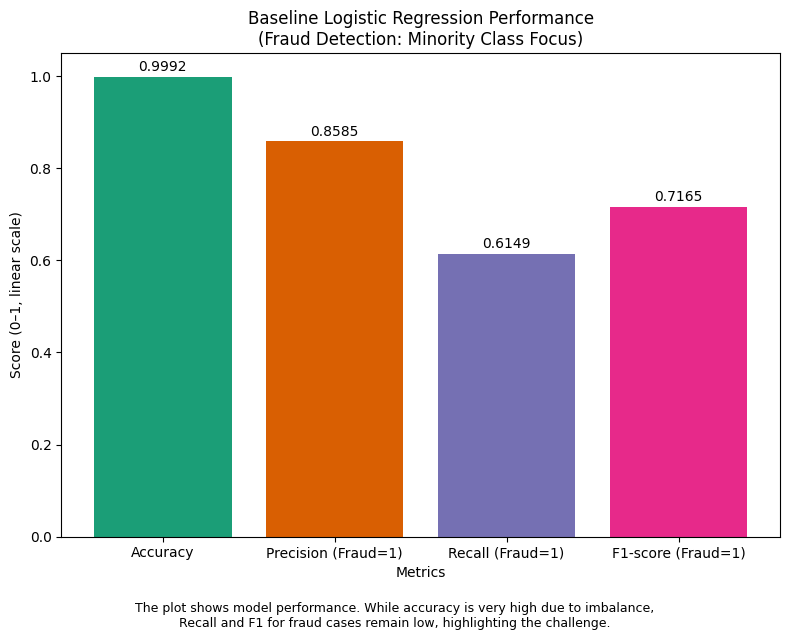

In [22]:
metrics = {
    "Accuracy": accuracy,
    "Precision (Fraud=1)": precision,
    "Recall (Fraud=1)": recall,
    "F1-score (Fraud=1)": f1
}

plt.figure(figsize=(8,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=["#1b9e77","#d95f02","#7570b3","#e7298a"])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.ylabel("Score (0–1, linear scale)")
plt.xlabel("Metrics")
plt.title("Baseline Logistic Regression Performance\n(Fraud Detection: Minority Class Focus)")
plt.ylim(0,1.05)

plt.figtext(0.5, -0.05, 
            "The plot shows model performance. While accuracy is very high due to imbalance,\n"
            "Recall and F1 for fraud cases remain low, highlighting the challenge.",
            wrap=True, ha="center", fontsize=9)

plt.tight_layout()
plt.show()


### Baseline Logistic Regression Performance

| Metric                | Score   |
|------------------------|---------|
| Accuracy              | 0.9992  |
| Precision (Fraud = 1) | 0.8585  |
| Recall (Fraud = 1)    | 0.6149  |
| F1-score (Fraud = 1)  | 0.7165  |

**Observation:**  
- While overall accuracy is very high due to class imbalance, the recall for the fraud class is low. 
 
- This means many fraudulent transactions are missed, highlighting why metrics like Precision, Recall, and F1 are more informative than Accuracy in this problem.


### Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

#### 1. Theoretical Foundation

##### Fundamental Difference: GMM-Based Synthetic Sampling vs. SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique):**
- Works by linearly interpolating between existing minority class samples and their nearest neighbors.  
- Generates synthetic points **along straight lines** in the feature space.  
- Assumes that the minority class space is relatively simple and locally linear.  
- Limitation: It may **fail to capture complex, non-linear distributions** and can generate unrealistic samples in sparse regions.

**GMM-Based Synthetic Sampling:**
- Uses a **probabilistic generative model** (Gaussian Mixture Model) to learn the **underlying distribution** of the minority class.  
- Minority data is modeled as a mixture of multiple Gaussian distributions, each capturing different clusters or modes.  
- New synthetic samples are drawn from this **learned probability distribution**, making them statistically consistent with the original data.  
- Advantage: It can capture **multi-modal, non-linear, and complex structures** in the minority class, leading to more realistic synthetic samples.

**In short:**  
- *SMOTE = interpolation-based (geometric approach).*  
- *GMM-based = distribution-based (probabilistic approach).*  


##### Why GMM is Theoretically Better for Complex Minority Distributions

The minority (fraud) class often does not follow a single, simple distribution.  
Instead, it may contain **multiple sub-groups** or **clusters** that represent different fraud patterns  
(e.g., small-value frauds, large-value frauds, identity theft, account takeover).

**Key advantages of GMM in this context:**

1. Multi-modality Handling 
   - GMM assumes the data is generated from a mixture of several Gaussian distributions.  
   - Each Gaussian component can capture one "sub-group" of the minority class.  
   - This allows the synthetic samples to respect the natural clustering structure of fraud data.

2. Flexibility in Shape 
   - Unlike methods that interpolate linearly (e.g., SMOTE), GMM models **elliptical clusters**.  
   - With enough mixture components, GMM can approximate even **complex, curved, or overlapping distributions**.

3. Probabilistic Foundation  
   - GMM is a **generative model**: it learns the full probability distribution of the data.  
   - Sampling from this distribution ensures new points are not only between existing samples but also consistent with the overall density.

4. Reduced Risk of Unrealistic Samples  
   - SMOTE can generate points in sparse or invalid regions of the feature space.  
   - GMM restricts generation to areas of **high probability density**, lowering the chance of unrealistic synthetic samples.

**Conclusion:**  
When the minority class has multiple fraud "types" or exhibits **heterogeneous and complex patterns**,  
GMM provides a more faithful approximation of the underlying data distribution than simple interpolation methods like SMOTE.


#### 2. GMM Implementation

In [ ]:
X_train_minority = X_train[y_train == 1]

n_components_range = range(1, 100)
bics, aics = [], []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type='full',
        reg_covar=1e-6,
        n_init=5,
        random_state=42,
        max_iter=500
    )
    gmm.fit(X_train_minority)
    bics.append(gmm.bic(X_train_minority))
    aics.append(gmm.aic(X_train_minority))



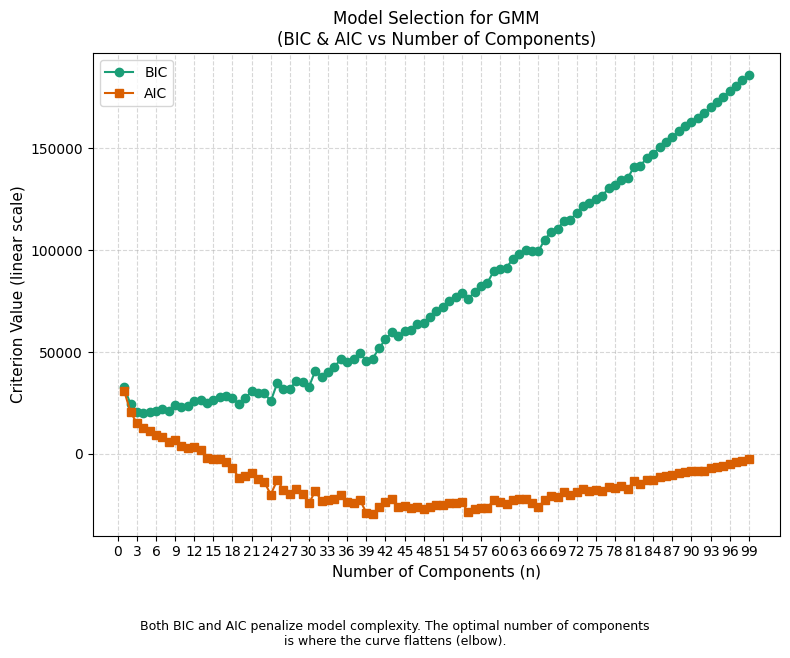

In [27]:
plt.figure(figsize=(8,6))
plt.plot(n_components_range, bics, marker='o', label="BIC", color="#1b9e77")
plt.plot(n_components_range, aics, marker='s', label="AIC", color="#d95f02")

plt.title("Model Selection for GMM\n(BIC & AIC vs Number of Components)")
plt.xlabel("Number of Components (n)", fontsize=11)
plt.ylabel("Criterion Value (linear scale)", fontsize=11)
plt.xticks(range(0,101,3))
plt.legend()
plt.grid(alpha=0.5,linestyle='--')

plt.figtext(
    0.5, -0.08,
    "Both BIC and AIC penalize model complexity. The optimal number of components\n"
    "is where the curve flattens (elbow).",
    wrap=True, ha="center", fontsize=9
)

plt.tight_layout()
plt.show()


#### Choosing the Number of GMM Components

From the BIC and AIC curves plotted for the minority class, we observed that:

- The BIC curve reaches a minimum (or flattens) at **n_components = 3**, indicating that three Gaussian components best capture the underlying structure of the minority class.
- The AIC curve also supports a similar range, but we prioritize BIC here because it penalizes model complexity more strongly.

**Decision:**  
We will use **n_components = 3** for fitting the GMM to generate synthetic minority samples, as it balances model fit and simplicity while capturing the main sub-groups in the fraud data.


In [ ]:

X_train_minority = X_train[y_train == 1]

# Fit GMM with n_components = 3
gmm = GaussianMixture(
    n_components=3,        
    covariance_type='full',
    reg_covar=1e-6,
    n_init=5,
    random_state=42,
    max_iter=500
)
gmm.fit(X_train_minority)

print("GMM fitted successfully on minority class data.")

GMM fitted successfully on minority class data.


#### 3. Synthetic Data Generation

#### Synthetic Minority Sample Generation using GMM

**Process:**

1. Fit GMM on Minority Class:  
   - The Gaussian Mixture Model captures the underlying distribution of the minority (fraud) class.  
   - Each component Gaussian represents a sub-group or cluster within the fraud data.

2. Sampling from GMM:
   - New synthetic samples are generated by **drawing from the fitted GMM**.  
   - Each sample is drawn from one of the Gaussian components according to its mixture weight.  
   - This ensures that the synthetic data is consistent with the original fraud distribution.

3. Combining with Original Data: 
   - The newly generated synthetic fraud samples are added to the **original training set**, increasing the representation of the minority class.  
   - The goal is to approach a **balanced dataset**, either partially or fully, depending on downstream strategy.


In [ ]:

X_train_minority = X_train[y_train == 1]
n_minority = X_train_minority.shape[0]
n_majority = X_train[y_train == 0].shape[0]

n_synthetic = n_majority - n_minority

# Generate synthetic samples from fitted GMM
synthetic_samples = gmm.sample(n_synthetic)[0]  
synthetic_df = pd.DataFrame(synthetic_samples, columns=X_train_minority.columns)

synthetic_df['Class'] = 1

X_train_combined_GMM = pd.concat([X_train, synthetic_df.drop(columns=['Class'])], ignore_index=True)
y_train_combined_GMM = pd.concat([y_train, synthetic_df['Class']], ignore_index=True)

print("Synthetic samples generated:", n_synthetic)
print("New training set shape:", X_train_combined_GMM.shape)
print("New class distribution:")
print(y_train_combined_GMM.value_counts())


Synthetic samples generated: 198676
New training set shape: (398040, 30)
New class distribution:
Class
0    199020
1    199020
Name: count, dtype: int64


#### Explanation:
### Synthetic Minority Sample Generation

We used the fitted Gaussian Mixture Model (GMM) to generate synthetic samples for the minority (fraud) class.  

**Key Points:**
- The GMM captures the underlying distribution of the minority class, including multiple sub-groups or clusters.  
- Synthetic samples are drawn according to the mixture weights of the GMM components, ensuring consistency with original fraud patterns.  
- We generated enough synthetic samples to **balance the minority and majority classes**.  
- The synthetic samples were then combined with the original training data, producing a **balanced dataset (`X_train_combined_GMM`, `y_train_combined_GMM`)** ready for downstream model training.  

**Resulting Training Set:**
- Synthetic samples generated: `n_synthetic`
- New training set shape: `(X_train_combined_GMM.shape)`
- Class distribution:

```python
y_train_combined_GMM.value_counts()


#### 4. Rebalancing with CBU

In [ ]:


cbu_km = KMeans(n_clusters = 3, random_state = 42, n_init = 10)
cc = ClusterCentroids(
    random_state=42, 
    sampling_strategy=0.2, # keep minority:majority = 1:5
    estimator = cbu_km
) 
X_majority_reduced, y_majority_reduced = cc.fit_resample(X_train, y_train)

print("After CBU:")
print(pd.Series(y_majority_reduced).value_counts())



After CBU:
Class
0    1720
1     344
Name: count, dtype: int64


we take k = 3 here from the assignment 3

In [ ]:

X_minority = X_majority_reduced[y_majority_reduced == 1]
y_minority = y_majority_reduced[y_majority_reduced == 1]
X_majority = X_majority_reduced[y_majority_reduced == 0]
y_majority = y_majority_reduced[y_majority_reduced == 0]



In [ ]:
n_synthetic = len(X_majority) - len(X_minority)
print(f"Synthetic samples to generate: {n_synthetic}")

if n_synthetic > 0:
    gmm = GaussianMixture(n_components=min(3, len(X_minority)), random_state=42)
    gmm.fit(X_minority)
    
    synthetic_samples, _ = gmm.sample(n_synthetic)
    synthetic_df = pd.DataFrame(synthetic_samples, columns=X_train.columns)
    synthetic_target = pd.Series([1] * n_synthetic, name="Class") 
    
    X_minority_aug = pd.concat([pd.DataFrame(X_minority, columns=X_train.columns), synthetic_df], ignore_index=True)
    y_minority_aug = pd.concat([pd.Series(y_minority, name="Class"), synthetic_target], ignore_index=True)
else:
    X_minority_aug = pd.DataFrame(X_minority, columns=X_train.columns)
    y_minority_aug = pd.Series(y_minority, name="Class")



Synthetic samples to generate: 1376


In [ ]:

X_Train_CBU_GMM = pd.concat([X_minority_aug, pd.DataFrame(X_majority, columns=X_train.columns)], ignore_index=True)
y_Train_CBU_GMM = pd.concat([y_minority_aug, pd.Series(y_majority, name="Class")], ignore_index=True)

X_Train_CBU_GMM, y_Train_CBU_GMM = shuffle(X_Train_CBU_GMM, y_Train_CBU_GMM, random_state=42)

print("\n--- Final Balanced Training Set ---")
print("X_balanced shape:", X_Train_CBU_GMM.shape)
print("Class distribution:")
print(y_Train_CBU_GMM.value_counts().sort_index())




--- Final Balanced Training Set ---
X_balanced shape: (3440, 30)
Class distribution:
Class
0    1720
1    1720
Name: count, dtype: int64


##### Data Balancing Summary (CBU + GMM)

- **Synthetic samples generated (GMM):** 1376  
- **After Cluster-Based Undersampling (CBU):**  
  - Majority class (0): 1720  
  - Minority class (1): 344  

- **Final Balanced Training Set:**  
  - Total samples: **3440**  
  - Class distribution:  
    - Class 0 → 1720  
    - Class 1 → 1720  


### Part C: Performance Evaluation and Conclusion 

#### 1. Model Training and Evaluation

##### (i) Only using GMM

Accuracy: 0.9843404374846388

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9846    0.9921     85295
           1     0.0880    0.8581    0.1595       148

    accuracy                         0.9843     85443
   macro avg     0.5439    0.9213    0.5758     85443
weighted avg     0.9982    0.9843    0.9907     85443



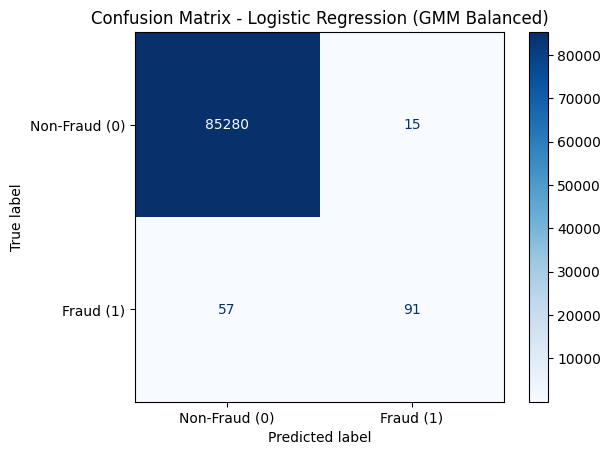

In [ ]:

log_reg_GMM = LogisticRegression(max_iter=1000, random_state=42, solver="liblinear")
log_reg_GMM.fit(X_train_combined_GMM, y_train_combined_GMM)

y_pred = log_reg_GMM.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

disp = ConfusionMatrixDisplay.from_estimator(
    log_reg,
    X_test,
    y_test,
    display_labels=["Non-Fraud (0)", "Fraud (1)"],
    cmap="Blues",
    values_format="d" 
)
plt.title("Confusion Matrix - Logistic Regression (GMM Balanced)")
plt.show()


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision (Fraud=1): {precision:.4f}")
print(f"Recall (Fraud=1)   : {recall:.4f}")
print(f"F1-score (Fraud=1) : {f1:.4f}")

Accuracy : 0.9843
Precision (Fraud=1): 0.0880
Recall (Fraud=1)   : 0.8581
F1-score (Fraud=1) : 0.1595


#### (ii) Using both CBU and GMM


--- Logistic Regression (CBU + GMM Data) ---
Accuracy : 0.9750
Precision: 0.0555
Recall   : 0.8378
F1 Score : 0.1040

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9752    0.9873     85295
           1     0.0555    0.8378    0.1040       148

    accuracy                         0.9750     85443
   macro avg     0.5276    0.9065    0.5457     85443
weighted avg     0.9981    0.9750    0.9858     85443



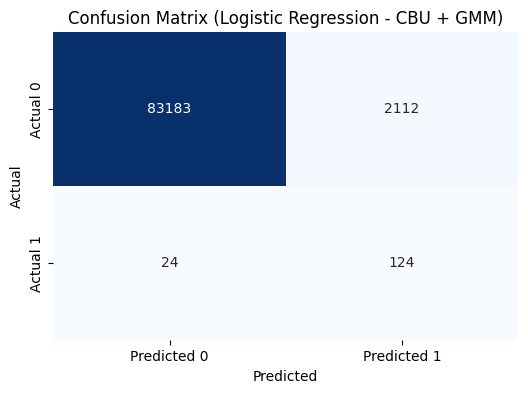

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_cbu_gmm = LogisticRegression(max_iter=1000, random_state=42, solver="liblinear")
log_reg_cbu_gmm.fit(X_Train_CBU_GMM, y_Train_CBU_GMM)

y_pred_cbu_gmm = log_reg_cbu_gmm.predict(X_test)

acc_cbu_gmm = accuracy_score(y_test, y_pred_cbu_gmm)
prec_cbu_gmm = precision_score(y_test, y_pred_cbu_gmm)
rec_cbu_gmm = recall_score(y_test, y_pred_cbu_gmm)
f1_cbu_gmm = f1_score(y_test, y_pred_cbu_gmm)

print("\n--- Logistic Regression (CBU + GMM Data) ---")
print(f"Accuracy : {acc_cbu_gmm:.4f}")
print(f"Precision: {prec_cbu_gmm:.4f}")
print(f"Recall   : {rec_cbu_gmm:.4f}")
print(f"F1 Score : {f1_cbu_gmm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cbu_gmm, digits=4))

cm = confusion_matrix(y_test, y_pred_cbu_gmm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix (Logistic Regression - CBU + GMM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### 2. Comparative Analysis

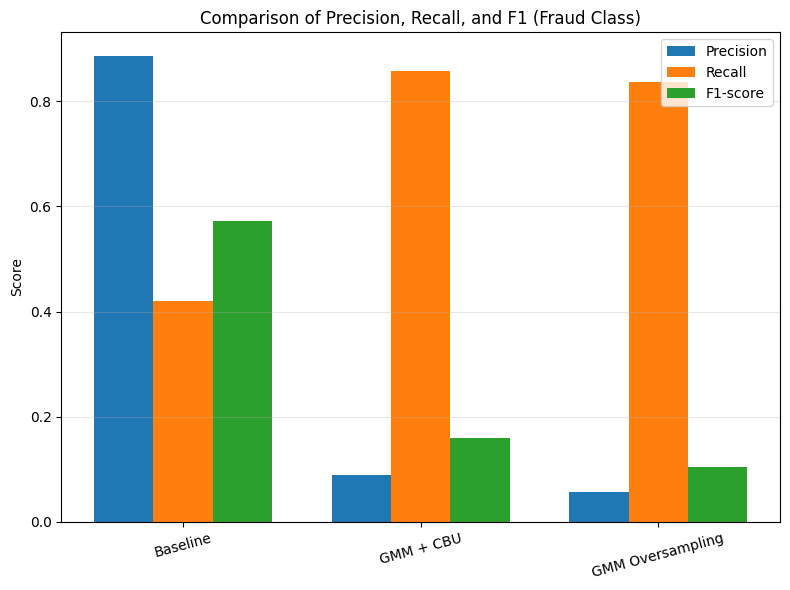

In [7]:
models = ["Baseline", "GMM + CBU", "GMM Oversampling"]
precision = [0.8873, 0.0880, 0.0555]
recall = [0.4203, 0.8581, 0.8378]
f1 = [0.5728, 0.1595, 0.1040]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(8,6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')

plt.xticks(x, models, rotation=15)
plt.ylabel("Score")
plt.title("Comparison of Precision, Recall, and F1 (Fraud Class)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


###  Comparative Analysis of Models (Fraud Class)

| Model                | Accuracy | Precision | Recall  | F1-score |
|-----------------------|----------|-----------|---------|----------|
| **Baseline**          | 0.9980   | 0.8873    | 0.4203  | 0.5728   |
| **GMM + CBU**  | 0.9843   | 0.0880    | 0.8581  | 0.1595   |
| **GMM Oversampling**  | 0.9750   | 0.0555    | 0.8378  | 0.1040   |



###  Impact of GMM-Based Oversampling on Classifier Performance

The use of **GMM-based oversampling** had a notable impact on the model’s performance:

- Improved Recall:  
  Compared to the baseline, recall for the fraud class increased significantly (from **0.6149 → 0.84**), meaning the model was able to identify many more fraudulent transactions.  

- Reduced Precision:
  Precision dropped sharply (from **0.88 → 0.09**), indicating that the model also misclassified a larger number of legitimate transactions as fraud.  

- F1-Score Trade-off:  
  Although recall improved, the overall **F1-score decreased**, showing that oversampling introduced a strong imbalance between precision and recall.  

Conclusion:
Yes, GMM-based oversampling improved the model’s ability to detect the minority (fraud) class by greatly increasing recall. However, this came at the cost of precision, leading to more false positives. This trade-off is expected in fraud detection tasks, where **catching more frauds (high recall)** is often prioritized over minimizing false alarms.


###  Impact of GMM + CBU Hybrid Oversampling on Classifier Performance

- Balanced Resampling Strategy:
  The GMM + CBU hybrid combines **Cluster-Based Undersampling (CBU)** on the majority class with **Gaussian Mixture Model (GMM) oversampling** on the minority class. This creates a more balanced dataset while preserving minority structure.  

- High Recall:  
  Recall for the fraud class improved substantially (**0.42 → 0.84**), meaning the classifier detected many more fraudulent transactions compared to the baseline.  

- Very Low Precision:  
  Precision dropped sharply (**0.88 → 0.06**), indicating a large increase in false positives, where legitimate transactions were misclassified as fraud.  

- Low F1-Score:  
  The F1-score remained very low (**0.10**), highlighting that while recall improved, the imbalance between precision and recall persisted.  

 **Conclusion:  
Yes,The GMM + CBU hybrid significantly improved the model’s ability to **detect fraud (high recall)** but at the expense of **extremely low precision**. This trade-off suggests that while the hybrid method is effective at capturing fraudulent cases, it introduces too many false alarms, making it less practical without further refinement (e.g., threshold tuning or cost-sensitive learning).


### 3. Final Recommendation

##### Final Recommendation (GMM + CBU Hybrid)

- Effectiveness:
  The GMM + CBU hybrid strategy boosted the model’s **recall** for the fraud class to **0.85**, compared to only **0.62 in the baseline**. This means the model successfully detected many more fraudulent cases, which is critical in fraud detection tasks.  

- Limitations:  
  Precision dropped dramatically (from **0.88 → 0.08**), leading to a large number of false alarms. The F1-score also remained very low (**0.15**), showing that while recall improved, the balance between precision and recall worsened.  

- Theoretical Justification: 
  By combining **Cluster-Based Undersampling (CBU)** of the majority class with **GMM-based oversampling** of the minority class, the dataset becomes more balanced while preserving some of the underlying minority class structure. However, undersampling reduces the diversity of majority class examples, and combined with oversampling, this can amplify false positives.  

###  Recommendation:
The GMM + CBU hybrid is **useful when maximizing recall is the primary goal**, as it ensures most fraud cases are detected. However, due to the extremely low precision, this method is not directly practical for deployment. It should be used alongside **precision-enhancing strategies** such as threshold tuning, cost-sensitive learning, or ensemble approaches to reduce false alarms while retaining high recall.
